## 논문 구현따라하기 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:

!wget "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"


--2023-03-08 01:13:49--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz.1’

flower_photos.tgz.1 100%[===================>] 218.21M   243MB/s    in 0.9s    

2023-03-08 01:13:50 (243 MB/s) - ‘flower_photos.tgz.1’ saved [228813984/228813984]



In [ ]:
!tar -xvzf /content/flower_photos.tgz

In [ ]:
from sklearn.model_selection import train_test_split
# 학습 데이터와 평가 데이터셋을 자동으로 분리
import glob
import os
dataset_path = '/content/flower_photos'
folder_name = ['daisy','dandelion','roses','sunflowers','tulips']

dataset = []
labels = []

for idx,folder in enumerate(folder_name) :
    img_dir_name = os.path.join(dataset_path,folder)
    files = glob.glob(img_dir_name + '/*')
    print(files)
    for file in files:
        img = Image.open(file)
        img = img.convert('RGB')
        img = img.resize((64,64))
        data = np.asarray(img)
        dataset.append(data)
        labels.append(idx)
    
datasets = np.array(dataset)
labels = np.array(labels)

3670


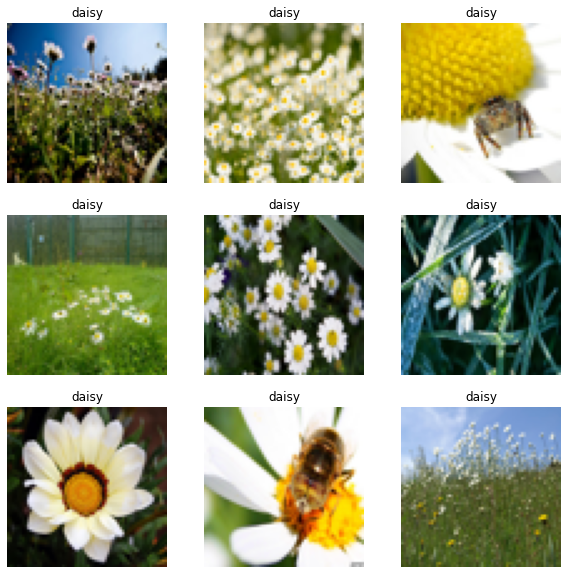

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(datasets[i].astype("uint8"))
    plt.title(folder_name[labels[i]])
    plt.axis("off")

In [7]:
x_train, x_test, y_train, y_test = train_test_split(datasets,labels,test_size=0.1)

In [8]:
xy = (x_train, x_test, y_train, y_test)
np.save('dataset.npy',xy)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
#함수형 방식 , functional 방식
x_train = x_train / 255.0
x_test = x_test / 255.0
import tensorflow as tf
from tensorflow.keras.layers import Input
input_img = Input(shape = (64,64,3) ,name='input_start')

from tensorflow.keras.layers import Conv2D, MaxPooling2D
tower_0 = Conv2D(64, (1,1) , padding='same',activation='relu',name = 'tower_0_start')(input_img)
####
tower_1 = Conv2D(64, (1,1) , padding='same',activation='relu', name = 'tower_1_start')(input_img)
tower_1 = Conv2D(64, (3,3) , padding='same',activation='relu')(tower_1)
###

tower_2 = MaxPooling2D((3,3) , strides=(1,1), padding='same')(input_img)
tower_2 = Conv2D(64, (3,3) , padding='same',activation='relu')(tower_2)


tower_3 = Conv2D(64, (1,1) , padding='same',activation='relu')(input_img)
tower_3 = Conv2D(64, (3,3) , padding='same',activation='relu')(tower_3)
tower_3 = Conv2D(64, (3,3) , padding='same',activation='relu')(tower_3)
##
output = tf.keras.layers.concatenate([tower_0,tower_1,tower_2,
                                      tower_3], axis = 3)

from tensorflow.keras.layers import Flatten, Dense
output = Flatten()(output)
#out = Dense(5, activation = 'sigmoid')(output)
out = Dense(5, activation = 'softmax')(output)

from tensorflow.keras.models import Model
model = Model(inputs = input_img, outputs = out)

print(model.summary())
from tensorflow.keras.optimizers import SGD
momentum_param = 0.9
lrate = 0.1
sgd = SGD(learning_rate = lrate, momentum = momentum_param)

model.compile(loss= 'sparse_categorical_crossentropy', optimizer = 'adam',metrics=['accuracy'])
model.fit(x_train, y_train, 
          validation_data= (x_test,y_test),
          epochs=10, batch_size=64)

In [16]:

test_path = '/content/flower_photos/dandelion/10477378514_9ffbcec4cf_m.jpg'

img = Image.open(test_path)
img = img.convert('RGB')
img = img.resize((64,64))
data = np.asarray(img)

result = model.predict(np.array([data]))

1/1 [==============================] - 0s 99ms/step
[[0. 0. 0. 1. 0.]]


In [20]:
print( f'{folder_name[np.argmax(result)]} 라고 예측 됩니다.')

sunflowers 라고 예측 됩니다.


In [22]:
# fine tuning
# 이미 학습이 완료된 모델을 들고와 우리의 목적에 맞게 튜닝(재학습)을 하는것
# 사전 학습 모델, 프리트레인 모델(pretrained model)
# 모델명: weights= 'imagenet'
# https://keras.io/api/applications/inceptionv3/
base_model = tf.keras.applications.InceptionV3(weights = 'imagenet',
                                               include_top= False,
                                               input_shape=(224,224,3))


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()
#우리의 데이터가 적은 경우  뒤 레이어 10% ~ 20 %만 학습
#우리의 데이터가 상대적으로 더 많은 경우 70~100% 만 학습

for layer in base_model.layers[:250]:
    layer.trainable = False

In [ ]:
base_model.summary()
#논문에서 기재된 러닝레이트에서 1/10로 축소
#논문 0.045 -> 우리 0.0045
#왜? 이미 해당모델은 학습이 됨. 우리는 우리 목적에 맞게끔 아주 조금만 수정하면됨

## 우리것으로 파인 튜닝해보기 

In [38]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
#분류 5개로
y = layers.Dense(5, activation = 'softmax')(x)

In [39]:
model = tf.keras.models.Model(inputs = base_model.input,
                              outputs = y)

In [40]:
model.summary()
#논문에서 기재된 러닝레이트에서 1/10로 축소
#논문 0.045 -> 우리 0.0045
#왜? 이미 해당모델은 학습이 됨. 우리는 우리 목적에 맞게끔 아주 조금만 수정하면됨
model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.0045), 'sparse_categorical_crossentropy')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_5[0][0]']               
 alization)                     )                                                           